In [4]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)

### Prepocessing
Данные взяты [отсюда](https://www.kaggle.com/datasets/trisha2094/weatheraus).

In [59]:
df = pd.read_csv('weatherAUS.csv')

target_mapper = {
    'Yes': 1,
    'No': 0
}

df['RainTomorrow'] = df['RainTomorrow'].map(lambda val: target_mapper.get(val, np.nan))

# drop NaN values
df.dropna(subset=['RainTomorrow'], inplace=True)

df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0           W           44.0          W        WNW          20.0   
1         WNW           44.0        NNW        WSW           4.0   
2         WSW           46.0          W        WSW          19.0   
3          NE           24.0         SE          E          11.0   
4           W           41.0        ENE         NW           7.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          24.0         71.0         22.0       1007.7       1007.1       8.0   
1          22.0         44.0         25.0       1010.6       1007.8       NaN   
2          26.0         38.0         30.0       1007.6       1008.7       NaN   
3           9.0         45.0         16.0       1017.6       1012.8       NaN   
4          20.0         82.0         33.0       1010.8       1006.0       7.0   

   Cloud3pm  Temp9am  Temp3pm RainToday  RainTomorrow  
0       NaN     16.9     21.8        No           0.0  
1       NaN     17.2     24.3        No           0.0  
2       2.0     21.0     23.2        No           0.0  
3       NaN     18.1     26.5        No           0.0  
4       8.0     17.8     29.7        No           0.0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

### Исследуем таргет

**RainTomorrow**

In [19]:
df['RainTomorrow'].value_counts()

RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

In [20]:
df['RainTomorrow'].value_counts(normalize=True)

RainTomorrow
No     0.775819
Yes    0.224181
Name: proportion, dtype: float64

#### Feature engineering

- Date     -> возьмем месяц и посмотрим его на следующую дату (-)
- Location -> берем и делаем dummy (-)
- MinTemp, MaxTemp, Temp9am, Temp3pm -> берем и объединяем в одну (замещаем средними показателями за календарный месяц)
- Rainfall -> берем вместо переменной RainToday (same)
- Evaporation, Sunshine -> берем, вместо пропущенных вставляем средние за месяц (same)
- WindGustDir, WindDir9am, WindDir3pm -> берем и может сделаем одну (вставляем строку NA)
- WindGustSpeed, WindSpeed9am, WindSpeed3pm -> берем и объединяем в одну (замещаем средними показателями за календарный месяц)
- ... (same)

- скомбинируем переменные Location и Wind (переменная взаимодействия / interaction term)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null   fl

In [25]:
df[['WindGustDir', 'WindDir9am', 'WindDir3pm']].isna().sum()

WindGustDir     9330
WindDir9am     10013
WindDir3pm      3778
dtype: int64

### Объединим несколько переменных в одну

In [27]:
temp_vars = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']
df_temp = df[temp_vars].dropna()

In [29]:
# для начала надо проверить, насколько они вообще пригодны для этой цели

df_temp.corr().round(2)

MinTemp  MaxTemp  Temp9am  Temp3pm
MinTemp     1.00     0.73     0.90     0.71
MaxTemp     0.73     1.00     0.89     0.98
Temp9am     0.90     0.89     1.00     0.86
Temp3pm     0.71     0.98     0.86     1.00

**Метод главных компонент (PCA)**

В PCA следует подавать стандартизированные данные.

In [49]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [50]:
sc = StandardScaler()
sc.fit(df_temp)
df_temp_sc = sc.transform(df_temp)

In [54]:
pc = PCA(n_components=df_temp.columns.size)
temp_new = pd.DataFrame(pc.fit_transform(df_temp_sc), columns=[f'PC{i + 1}' for i in range(df_temp.columns.size)])

In [55]:
temp_new.corr().round(2)

PC1  PC2  PC3  PC4
PC1  1.0 -0.0 -0.0  0.0
PC2 -0.0  1.0  0.0 -0.0
PC3 -0.0  0.0  1.0  0.0
PC4  0.0 -0.0  0.0  1.0

Как выбрать количество компонент, которые получатся на выходе?

Построим **Scree plot**:

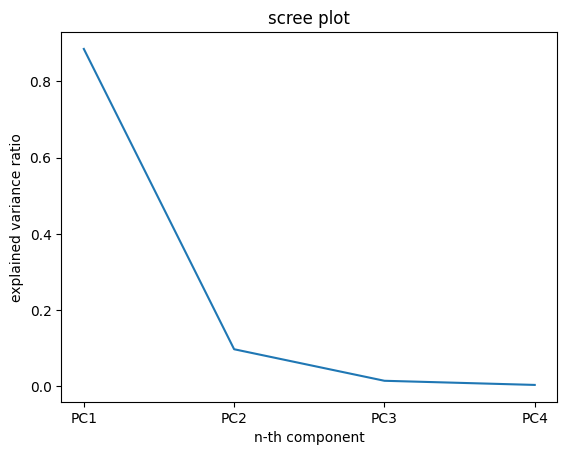

In [56]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(np.arange(1, 5), pc.explained_variance_ratio_)

ax.set_title('scree plot')
ax.set_xlabel('n-th component')
ax.set_ylabel('explained variance ratio')

ax.set_xticks(np.arange(1, 5), temp_new.columns);

Еще способы:

- PCA-like способы (для sparse - разреженных данных);
- нелинейные вариации PCA;
- автоэнкодеры;
- ...

#### Продолжаем